# Dark Patterns Trawler

This file contains all the scripts necessary to obtain raw data from Reddit's 'r/assholedesign' subreddit community. It also contains the scripts to analyze coded samples of the raw data.  

## Scraping
The first step is to retrieve raw data from the subreddit '/r/assholedesign'. My goal was to obtain as much as possible. In these cells, the key dependency is the `praw` library, which allows one to easily download data from Reddit. 

In [3]:
import praw
import urllib.request
import logging

# from textblob import TextBlob

import pandas as pd

from datetime import datetime
import time
import os.path

In [4]:
""" File path to Reddit credentials """
REDDIT_CREDENTIALS_FPATH = "/u/mopena/REDDIT/REDDIT_API_CREDENTIALS.txt"

""" File path to image storage folder """
OUTPUT_FOLDER = "/u/mopena/REDDIT/IMAGES/"

""" Name of the subreddit /r/assholedesign """
SUBREDDIT_NAME = "assholedesign"

""" Permissible flairs to store data from subreddit """
ALLOWED_FLAIRS = [None, "Bad Unsubscribe Function", "Clickshaming", "Dark Pattern", \
                  "Bait and Switch", "Loaded Question"]

""" Standard identifiers of images """
IMAGE_TAGS = ["i.redd.it", ".png", ".jpg", ".gif"]

""" Standard identifiers of videos """
VIDEO_TAGS = ["v.redd.it", ".mp4", ".mov"]

""" List of columns in output data """
COLUMN_LIST = ["ID", "Title", "Title_Language", "Media_Type", "Media_URL", "Date_Time", "Flair", \
               "Local_File_Name", "Is_OC", "Score", "Upvote_Ratio"]

""" Praw library upper bound on number of posts """
UPPER_BOUND = 1000

When this code is run for the first time, I recommend using the first set of parsing parameters (all, year, month, week, day, hour). By doing so, one can start strong, with as much data from the subreddit as possible. Then, run these cells once a week to collect the most recent data every week. 

In [ ]:
""" List of parameters to control parsing """
# PARSING_PARAMS = [("all", UPPER_BOUND), ("year", UPPER_BOUND), ("month", UPPER_BOUND), \
#                  ("week", UPPER_BOUND), ("day", UPPER_BOUND), ("hour", UPPER_BOUND)]
PARSING_PARAMS = [("day", UPPER_BOUND), ("week", UPPER_BOUND)]

In [10]:
def get_credentialed_parser(filepath: str=REDDIT_CREDENTIALS_FPATH): 
    """ Retrieves Reddit credentials from local file and returns parser object """
    REDDIT_CREDENTIALS_FILE = open(filepath, 'r')
    REDDIT_CREDENTIALS = REDDIT_CREDENTIALS_FILE.read().split('\n')
    # Access credentials in file
    REDDIT_PERSONAL_USE_SCRIPT = REDDIT_CREDENTIALS[0]
    REDDIT_SECRET_KEY = REDDIT_CREDENTIALS[1]
    REDDIT_APP_NAME = REDDIT_CREDENTIALS[2]
    REDDIT_USER_NAME = REDDIT_CREDENTIALS[3]
    REDDIT_LOGIN_PASSWORD = REDDIT_CREDENTIALS[4]
    # Plug credentials in
    reddit = praw.Reddit(client_id=REDDIT_PERSONAL_USE_SCRIPT, \
                     client_secret=REDDIT_SECRET_KEY, \
                     user_agent=REDDIT_APP_NAME, \
                     username=REDDIT_USER_NAME, \
                     password=REDDIT_LOGIN_PASSWORD)
    return reddit

In [11]:
def get_time_from_unix(timestamp: int): 
    """ Return date & time given a Unix timestamp """
    return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
def retrieve_image(submission_url, submission_localname): 
    """ Retrieve a file from the Internet and store """
    urllib.request.urlretrieve(submission_url, submission_localname)

In [13]:
def process_submission(submission) -> dict: 
    """ Return a dictionary encoding data on a submission """
    # Removes all posts without URLs (i.e. posts without visual media)
    if submission.is_self: return {0: -1}
    # Removes all posts without the proper flairs
    if submission.link_flair_text not in ALLOWED_FLAIRS: return {0: -1}
    # Removes all posts with low score (might not be "asshole design")
    if submission.upvote_ratio < 0.6: return {0: -1}
    # Determines if the title is English
    # title_obj = TextBlob(submission.title)
    # title_lang = title_obj.detect_language()
    # if title_lang != "en": return {0: -1}
    # Parses date & time
    submission_datetime = get_time_from_unix(int(float(submission.created_utc)))
    # Decides if media is image or video
    submission_type = "Other"
    submission_url = submission.url
    if any([img_tag in submission_url for img_tag in IMAGE_TAGS]): submission_type = "Image"
    elif any([vid_tag in submission_url for vid_tag in VIDEO_TAGS]): submission_type = "Video"
    elif "imgur.com" in submission_url: submission_type = "Imgur_Non_Image"
    # Assigns the media a file location on local machine
    submission_localname = OUTPUT_FOLDER + submission.id + "." + submission_url.split('.')[-1]
    # Retrieves images to local machine
    if submission_type == "Image" and not os.path.isfile(submission_localname): 
        try: retrieve_image(submission_url, submission_localname)
        except: 
            exceptionstr = f"EXCEPTION detected on saving {submission_url} to {submission_localname}"
            print(exceptionstr)
            logging.debug(exceptionstr)
    else: submission_localname = "NA"
    # Saves all the data
    rowdict = {}
    rowdict["ID"] = submission.id
    rowdict["Title"] = submission.title.replace('\t', '')
    rowdict["Title_Language"] = "en" # title_lang
    rowdict["Media_Type"] = submission_type
    rowdict["Media_URL"] = submission_url
    rowdict["Date_Time"] = submission_datetime
    flair = submission.link_flair_text
    if flair != None: flair = flair.replace('\t', '')
    rowdict["Flair"] = flair
    rowdict["Local_File_Name"] = '/'.join(submission_localname.split('/')[3:])
    rowdict["Is_OC"] = submission.is_original_content
    rowdict["Score"] = submission.score
    rowdict["Upvote_Ratio"] = submission.upvote_ratio

    return rowdict

In [14]:
def retrieve_top(subreddit, timelabel:str="day", limit:int=UPPER_BOUND) -> pd.DataFrame:
    """ Return a DataFrame of the N top submissions over a given time horizon """
    top_submissions = subreddit.top(timelabel, limit=limit)
    data_rowslist = []
    outfile = open(OUTPUT_FOLDER + "DATA_partial.txt", 'a')
    for submission in top_submissions:
        # Process a submission with timer code
        starttime = time.time()
        rowdict = process_submission(submission)
        endtime = time.time()
        if 0 in rowdict.keys() and rowdict[0] == -1: continue
        # Print submission ID
        infostr = "Current ID: " + rowdict["ID"]
        timestr = f"Time elapsed: {(endtime - starttime) / 1000:.03f} sec"
        print(infostr + '\t' + timestr)
        logging.debug(infostr)
        logging.debug(timestr)
        # Writes data to list and output file
        data_rowslist.append(rowdict)
        rowlist = [str(val) for val in rowdict.values()]
        outfile.write('\t'.join(rowlist) + '\n')
    outfile.close()
    # Saves list to Pandas DataFrame
    data = pd.DataFrame(data_rowslist, columns=COLUMN_LIST)
    return data

In [ ]:
""" Runs through provided parsing parameters """
log_path = OUTPUT_FOLDER + "log.txt"
logging.basicConfig(level=logging.DEBUG, filename=log_path, filemode="w+", \
                    format="%(asctime)-15s %(levelname)-8s %(message)s")
reddit = get_credentialed_parser()
subreddit = reddit.subreddit('assholedesign')
alldata = pd.DataFrame([], columns=COLUMN_LIST)
for paramtup in PARSING_PARAMS: 
    timelabel = paramtup[0]
    limit = paramtup[1]
    trialstr = f"Retrieving up to the top {limit} posts across {timelabel}"
    print("=================================================")
    print(trialstr)
    logging.info("=================================================")
    logging.info(trialstr)
    # Add data and drop submissions with duplicate ID
    data = retrieve_top(subreddit, timelabel=timelabel, limit=limit)
    alldata = pd.concat([alldata, data], axis=0)
    alldata.drop_duplicates(subset="ID", inplace=True)
# Save all data to a file
print("=================================================")
logging.info("=================================================")
alldata.to_csv(OUTPUT_FOLDER + "DATA.txt", sep='\t', index=False)

## Pre-processing

After retrieving raw data from Reddit, I performed a manual analysis (coding, but in the social sciences sense). To facilitate the coding process, I used the following scripts to sample $n$ datapoints from the population. 

In [10]:
# Setup for new round of coding
import pandas as pd
import glob, os
from random import sample
import shutil

dirpath = "/Users/openamiguel/Documents/REDDIT/"
os.chdir(dirpath)
df = pd.read_csv(f"DATA_all.txt", sep='\t')

In [11]:
# Save a certain number of images to a special folder
num_files = 20
analysis_num = 1
indices = [i for i in range(len(df))]
sampled_indices = sample(indices, len(df))

i = 0
j = 0
os.chdir(dirpath + "IMAGES/")
while i < num_files: 
    idx = sampled_indices[j]
    j = j + 1
    file_id = df.loc[idx, 'ID']
    sourcelist = glob.glob(file_id + ".*")
    if len(sourcelist) == 0: continue
    print(file_id)
    source = sourcelist[0]
    target = f"{dirpath}CODING_{analysis_num:02d}/" + source
    try: shutil.copyfile(source, target)
    except IOError as e:
        print(f"Unable to copy file. {e:s}")
        exit(1)
    except: 
        print(f"Unexpected error: {sys.exc_info()}")
        exit(1)
    i = i + 1

print(f"Total number of files: {i}")

dwfdef
acy7ry
fhxhny
fg1ufd
feyru1
fjcjq5
ff0g82
9riwq2
7t2og3
fdmy5o
bhfd0b
8ocgxp
9mrep3
e0yka2
fm08n6
dhdt0t
bvlwsi
abxtvw
blpiiu
8y9s91
Total number of files: 20


## Data analysis

Next, I passed the coded data into some scripts that plot the data in. The comments in the following cells indicate my general approach, even if the details are irrelevant to other projects. 

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load data from a file
dirpath = "/Users/openamiguel/Documents/REDDIT/"
os.chdir(dirpath)
df = pd.read_csv("CODING_ALL.txt", sep='\t')

# Add column names to data
columns = ["ID", "Title_Artifacts", "Title_Code", "Is_Asshole_Design", "Modality_Code", "Interaction_Domain_Code", "Interaction_Purpose_Code", "Is_Dark_Pattern", "Dark_Pattern_Code"]
df.columns = columns

# Filter out posts that are not asshole design
df_filtered = df[df.Is_Asshole_Design == "Y;Y;Y"]

# Filter out posts that are not dark patterns
df_filtered = df_filtered[df_filtered.Is_Dark_Pattern == "Y"]

print(df_filtered.head())
print()
print(f"Length of dataframe: {len(df_filtered)}")

       ID                                    Title_Artifacts Title_Code  \
0  b0qpuz                                     Black very low       EC;S   
1  b9az02               Enriched with Vitamin A;Vitamin A 0%          U   
2  b9uuf8  EVICTION NOTICE: We regret to inform you that ...         EC   
3  bam9n9   Are you sure you want to cancel a free download?          F   
5  bzrz6k  3 FREE months of Uconnect Access. Press the Ca...          U   

  Is_Asshole_Design Modality_Code Interaction_Domain_Code  \
0             Y;Y;Y             O                      PP   
1             Y;Y;Y             P                      PP   
2             Y;Y;Y             P                       C   
3             Y;Y;Y             C                      PS   
5             Y;Y;Y             O                      PP   

  Interaction_Purpose_Code Is_Dark_Pattern Dark_Pattern_Code  
0                       IN               Y                HI  
1                       PA               Y              

In [ ]:
# Retrieve dates of all the dark patterns posts
dirpath = "/Users/openamiguel/Documents/REDDIT/"
os.chdir(dirpath)
list_dates = []
df_all = pd.read_csv("DATA_all.txt", sep='\t')

for id_str in df_filtered.ID: 
    df_date = df_all.Date_Time[df_all.ID == id_str]
    list_dates.append(df_date.iloc[0])
list_dates.sort()

print(list_dates)

In [8]:
# Subsumes certain codes with a broader category
def get_code_replace(): 
    code_replace = dict()
    replace_1 = ['RM', 'PC', 'IC'] # Replace with 'O'
    replace_2 = ['FC', 'HC', 'SB', 'BAS'] # Replace with 'S'
    replace_3 = ['HI', 'PS', 'AM', 'TE', 'FH', 'DA', 'TQ'] # Replace with 'II'
    replace_4 = ['SP', 'PZ', 'G'] # Replace with 'FA'
    replaces = ['O', 'S', 'II', 'FA']
    replace_list = [replace_1, replace_2, replace_3, replace_4]

    for newcode, oldlist in zip(replaces, replace_list): 
        for entry in oldlist: 
            code_replace[entry] = newcode
    
    return code_replace

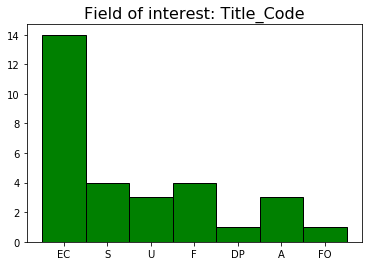

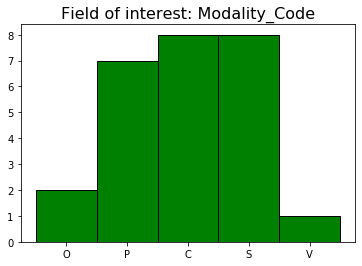

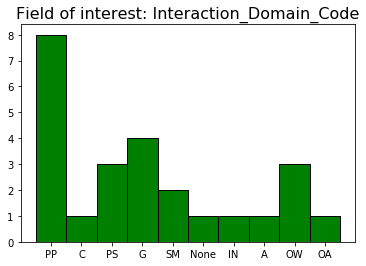

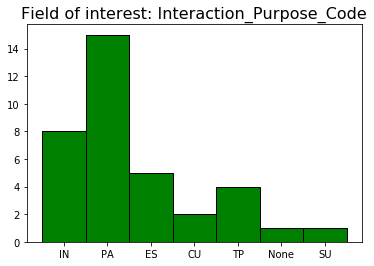

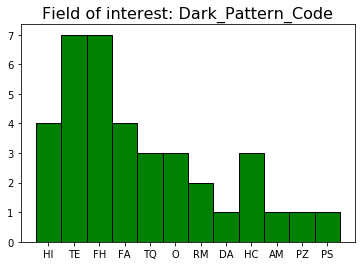

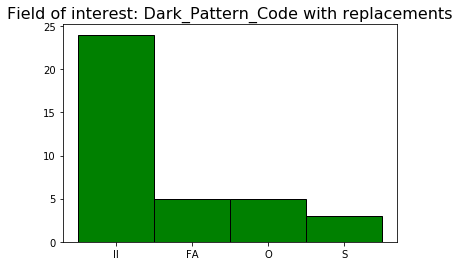

({'II': 24, 'FA': 5, 'O': 5, 'S': 3}, 37)

In [9]:
# Plot data from a column as a bar graph
def plot_codes(field_of_interest: str, code_replace: dict={}): 
    codes = dict()
    for row in df_filtered[field_of_interest]: 
        entries = row.split(';')
        for entry in entries: 
            entry_rep = entry
            if entry_rep in code_replace.keys(): 
                entry_rep = code_replace[entry_rep]
            if entry_rep in codes.keys(): 
                codes[entry_rep] = codes[entry_rep] + 1
            else:
                codes[entry_rep] = 1
    title = f"Field of interest: {field_of_interest}"
    if len(code_replace.keys()) > 0: title = title + " with replacements"
    plt.title(title, fontsize=16)
    plt.bar(codes.keys(), codes.values(), width=1, color='g', edgecolor='k')
    plt.show()
    
    return codes, np.sum(np.array(list(codes.values())))

for colname in columns:
    if "Code" in colname: plot_codes(colname)

plot_codes("Dark_Pattern_Code", code_replace=get_code_replace())